# FEM Theory

Here we describe the Theory behind the Finite Element Method (FEM) scheme we are using to solve the strongly damped wave equation.

## Numerical Scheme

The numerical scheme we are implementing is based on our basis functions for the discretization of space. Here we first describe that process more rigorously and then we proceed in describing the numerical scheme chosen to perform numerical analysis.

### The IVP

We are working on a cyllindrical domain $\Omega$ which is a subset of $\mathbb{R}^2$. Specifically:

$$\Omega = S^2 \times (0,1) \subset \mathbb{R}^2$$

Now we are attempting to solve Problem $P_1$ in that domain.

$$ 
P_1 = \begin{cases}
\Delta u(x,t) + \Delta u_{t}(x,t) - u_{tt}(x,t) = f(x,t) & \forall (x,t) \in \Omega \times \mathbb{R}^+\\
u(x,0) = 0 & \forall x \in \Omega\\
u(x,t) = 0 & \forall x \in \partial \Omega \times \mathbb{R}^+
\end{cases}
$$

Where $u(x,t)$ is our nondimensionalized pressure function, and $f(x,t)$ is the source term. We impose one more restriction to the equation which is that the source term f is axisymmetric. As a result, it is now possible to reduce our problem into two like so. Using cyllindrical coordinates around the symmetry axis of $f(x,t)$ we have that: $f(x,t) = f(r,z,t)$ hence we can rewrite:

$$u(r,\phi,z,t) = u(r,\phi,z,t)v(\phi)$$

Where the difference between $u(r,\phi,z,t)$ and $u(r,\phi,z,t)$ is understood. We hence have:

$$v \Delta_{rz} (u + u_{t}) + (u + u_{t}) \Delta_{\phi} v  - v u_{tt} = f $$

Here a solution immediately becomes apparent. $v(\phi)=1$. We henceforth reduce our equation to cyllindrically symmetric solutions with that condition. This restriction will convert the 3D problem into 2D dramatically decreasing computation time.

**Proposition:** A solution $u(r,\phi,z,t)$ of the axisymmetric version of $P_1$ has a local extremum at $r = 0$.

**Proof:** Note that $u(r,\phi_1,z,t)$ = $u(r,\phi_2,z,t)$. We now employ the smoothness of the solution. Specifically, for any smooth path $\gamma : [0,1] \to \Omega$ such that $\exists\ \alpha \in [0,1] \text{ s.t. } \gamma(\alpha) = 0 \in \Omega$ then the function $\tilde{u}$ defined by:

$$\tilde{u}:[0,1]\times \mathbb{R}^+ \to \mathbb{R}$$
$$\tilde{u}(s,t) \mapsto u(\gamma(s),t) \in \mathbb{R},$$

must be smooth. Then Use MVT. $\square$

Now that we have established these two conditions we can perform the 1 dinemensional reduction to $P_1$ from 3D to 2D, by elliminating $\phi$-dependance.


### Weak formulation

We can convert the wave equation to its weak formulation like so. Consider the space of all locally summable functions in $U = \Omega \times \mathbb{R}^+$ where their derivatives belong to $L^3(U)$, $H^3(U)$. Then, assuming a solution $u \in H^3(U)$ of $P_1$ then $\forall v \in H^3(U)$ the following must hold.

$$\int_\Omega \nabla v \cdot \nabla u\ dx \int_\Omega \nabla v \cdot \nabla u_t\ dx  + \int_\Omega v u\ dx + \int_\Omega v f\ dx$$

Now we define an inner product on the sobolev space $H^3(U)$ like so:

$$(\cdot,\cdot): H^3(U) \times H^3(U) \to \mathbb{R}$$
$$ (u,v) \mapsto \int_\Omega v u\ dx \in \mathbb{R}$$

by slightly abusing our notation we can rewrite our weak equation in terms of the inner product.

$$(\nabla v,\nabla u) + (\nabla v,\nabla u_{t}) + (v,u_tt) = - (v,f)$$

Hence, due to the linearity of the inner product we can define two linear functionals and restate our equation as follows:

$$\alpha (v,u) = (\nabla v,\nabla u) + (\nabla v,\nabla u_{t}) + (v,u_tt)$$
$$F(v) = - (v,f)$$

$$\alpha(v,u) = F(v)$$

Hence by Lax-Milgram Theorem we have shown that there exists a unique solution for the weak formulation of $P_1$

## Discretization

Now we will start approximating the solution. 

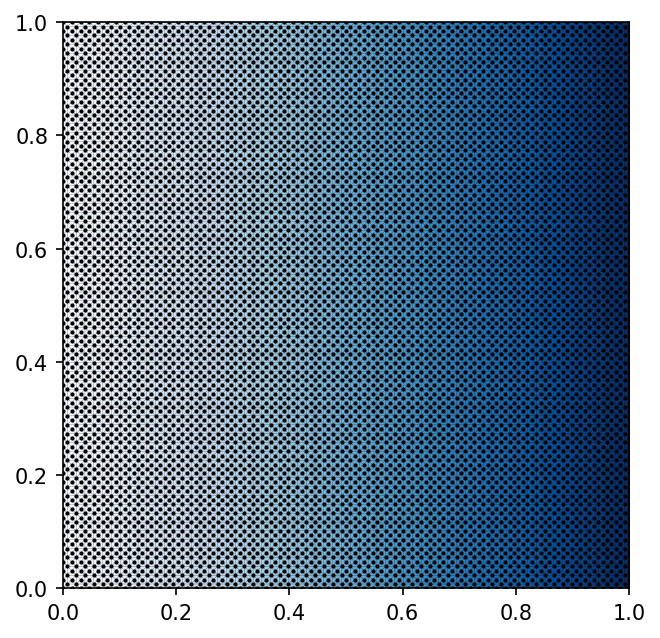

In [1]:
# Let's evaluate matrices S, and T and create a mesh for our domain.

# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm

# With this routine we will discretize a space using triangles according to a size distribution. 
# Set the bounds
r_bounds = (0,1)
z_bounds = (0,1)

# We will first create the first points
def merge(A,B):
    '''Merges two lists performing a set product A x B'''
    L = []
    for a in A:
        for b in B:
            L.append([a,b])
    return L

# Create the first 4 points.
points = merge(r_bounds,z_bounds)
ground_box = points.copy()

def center(box):
    '''Returns the central point of a box'''
    x = 0 
    y = 0
    for p in box:
        x+=p[0]
        y+=p[1]

    return (x/4,y/4)
points.append(center(ground_box))


# For the subdivision parameters
h = 2e-2                        # How course parameter
F = lambda r,z: abs(r)          # A function to do the subdivision
# F = lambda r,z: np.exp(-(r**2+z**2)/0.5)

# Now we recursively generate the rest of the points.
boxes = []            
box_q = [ground_box]            # We start with only one box on the queue

def create_box(point,box,points):
    '''Creates a new box on the grid'''
    new_box = [point]
    for p in box:
        if p == point: continue

        new_p = ((p[0] + point[0])/2,(p[1] + point[1])/2) # Create new point

        if new_p not in points:     # For if the point is new add it
            points.append(new_p)

        new_box.append(new_p)
    
    c = center(new_box)
    if c not in points: points.append(c)

    return new_box

def box_needed(point,box,F,h=h):
    '''Given a particular Function F, and a box, it returns weather or 
    not there needs to be a finer asjustment in the mesh at said point'''
    needed = False
    for p in box:
        if p == point: continue

        if abs(F(*p)-F(*point)) > h: return True

    return needed

# While there are boxes left to check
while len(box_q) > 0:
    box = box_q[0]                  # Get the current box

    # For all the points in the box
    # If we need to add a new box add it
    for point in box:
        if box_needed(point,box,F): 
            new_box = create_box(point,box,points)      # Create a box
            box_q.append(new_box)                       # Add the new box to the box queue

    # Remove the current box from the boxes 
    box_q.pop(0)

points = np.array(points)

# Let's reorder our points accordingly
def reorder(points):
    scores = np.array([len(points)*point[1]+point[0] for point in points])
    indx   = np.arange(0,len(points))

    sorted_pairs = sorted(zip(scores,indx))

    tuples = zip(*sorted_pairs)
    scores, indx = [ list(tuple) for tuple in  tuples]

    return points[indx]

# This step is important to get prettier sparse matrices
points = reorder(points)


# We can generate a mesh using Delaunay Triangulization
from scipy.spatial import Delaunay
mesh = Delaunay(points)

plt.figure(figsize=(5,5),dpi=150)
plt.scatter(*np.array(points).T,s=1,marker='o',c='k')

Npts = 50
r = np.linspace(*r_bounds,Npts)
z = np.linspace(*z_bounds,Npts)
extent = np.min(r), np.max(r), np.min(z), np.max(z)

R,Z = np.meshgrid(r,z)
FF = np.flip(F(R,Z),axis=0)
plt.imshow(FF,cmap=cm.Blues,interpolation='bilinear',extent=extent)

plt.triplot(points[:,0], points[:,1], mesh.simplices,lw=0.1,c='k');

In [2]:
# Having the triangles we need to get our S, and T matrices
# Let's start with T_ij which is the simpler one

N_points = len(points)

T = np.zeros((N_points,N_points))
S = np.zeros((N_points,N_points))

def get_simplices(tri, point):
    '''Find all simplices this point belongs to'''

    visited = set()
    queue = [tri.vertex_to_simplex[point]]
    while queue:
        simplex = queue.pop()
        for i, s in enumerate(tri.neighbors[simplex]):
            if tri.simplices[simplex][i] != point and s != -1 and s not in visited:
                queue.append(s)
        visited.add(simplex)
    return np.array(list(visited))

def jacobian(p):
    '''Calculates the jacobian of the triangle transformation given the 3 points'''
    return (p[1][0]-p[0][0])*(p[2][1]-p[1][1])-(p[2][0]-p[0][0])*(p[1][1]-p[0][1])

# The matrices with the integrals for T and S
A_T = np.pi/60 * np.array([[2,2,1],  [2,6,2], [1,2,2] ])
A_S = np.pi/3  * np.array([[2,-1,-1],[-1,1,0],[-1,0,1]])

# For all the points
for i in range(len(points)):
    # Find the neighboring triangles to x_i
    nei_tri = get_simplices(mesh,i)
    nei_pts = np.unique(mesh.simplices[nei_tri].reshape(-1))
    
    # For all the neighboring triangles
    for triangle in nei_tri:
        p_indx = mesh.simplices[triangle]    # Get the points for set triangle
        pts    = points[p_indx]             # Get the number of points
        J      = jacobian(pts)              # Calculate the jacobian for this triangle

        # the index (1,2,3) of the ith point is:
        ki = p_indx.tolist().index(i)

        for kj in range(len(p_indx)):        # For each of those points
            # We need to unpack if this point is 1,2, or 3.
            # To do that we use the index of the triangle list
            j = p_indx[kj]
            T[i][j] += A_T[ki][kj]*J
            S[i][j] += A_S[ki][kj]*J


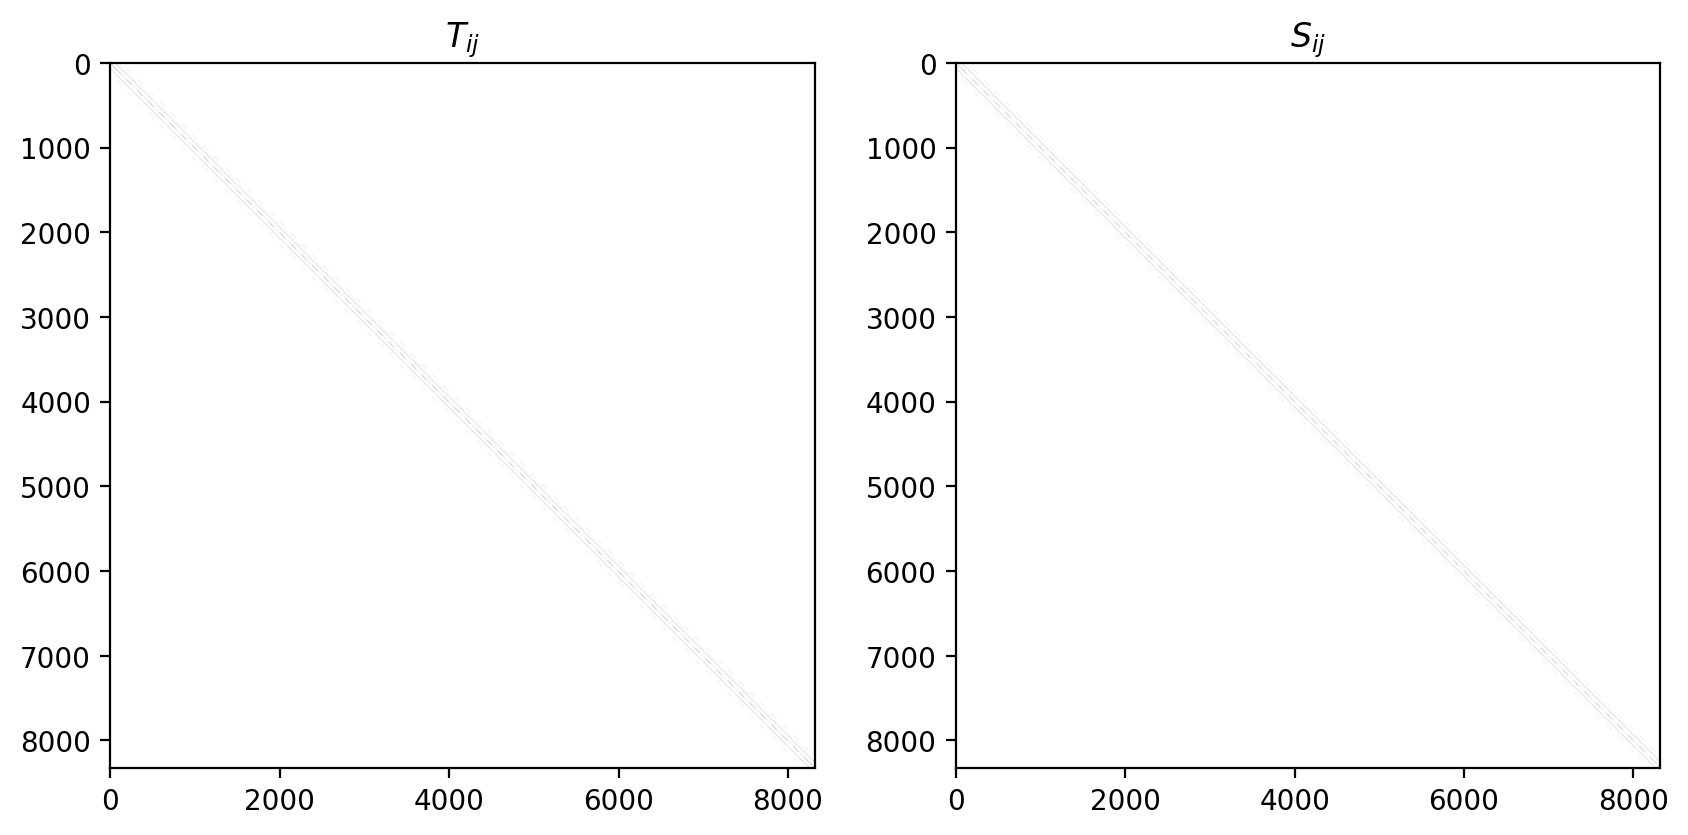

In [3]:
# The two sparse matrices visualised

fig = plt.figure(figsize=(10,5),dpi=200)
ax_T = fig.add_subplot(121)
ax_S = fig.add_subplot(122)
ax_T.imshow(T!=0,cmap=cm.binary)
ax_S.imshow(S!=0,cmap=cm.binary)

ax_T.set_title(r'$T_{ij}$');
ax_S.set_title(r'$S_{ij}$');

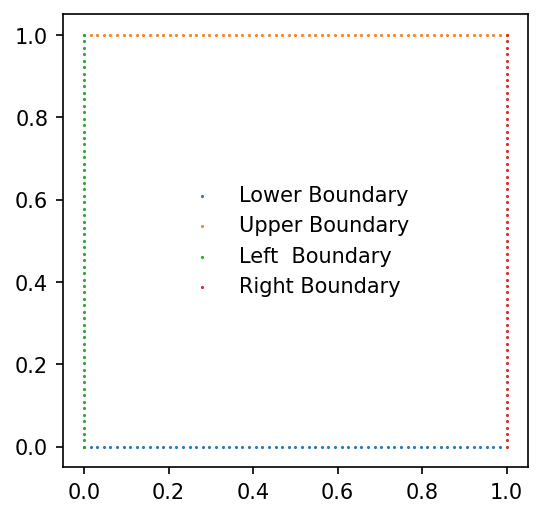

In [4]:
# Boundary Conditions
# To implement boundary conditions we have to identify the edges of our points. 


def get_boundary(points):
    '''Returns a list of boundary point indexes'''

    pts = points.tolist()
    bd_lower = np.arange(0,pts.index([1,0]))
    bd_upper = np.arange(pts.index([0,1]),len(pts))
    bd_left  = [pts.index(p) for p in pts if p[0]==0]
    bd_right = [pts.index(p) for p in pts if p[0]==1]

    return bd_lower,bd_upper,bd_left,bd_right

bd_lower,bd_upper,bd_left,bd_right = get_boundary(points)

# Print the boundary
plt.figure(figsize=(4,4),dpi=150)
plt.scatter(*points[bd_lower].T,label='Lower Boundary',marker='.',s=1)
plt.scatter(*points[bd_upper].T,label='Upper Boundary',marker='.',s=1)
plt.scatter(*points[bd_left].T, label='Left  Boundary',marker='.',s=1)
plt.scatter(*points[bd_right].T,label='Right Boundary',marker='.',s=1)
plt.legend(frameon=False);

In [5]:
# Now that we have these we only need to write a program that would solve the numerical scheme we have derived
# The numerical scheme is in the form A U_n+1 = B U_n + C U_n-1 + F

# So we will write something to solve A U = B and then proceed
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.linalg import solve

# Define appropriate simulation constants
dt = 1e-3   # Time step
v  = 1      # Source wave speed
s  = 1e-3   # Source std
o  = 0.1    # Source offset

# Define a Source function
f = lambda r,z,t: np.exp(-((z-v*t-o)**2 + r**2)/s)

# Define the initial condition vectors
# Goal is to solve for U_next, using U_curr and U_prev
U_curr = np.zeros(len(points))
U_prev = np.zeros(len(points))
U_next = np.zeros(len(points))
F      = np.array([f(*point,0) for point in points])


# Define the relevant numerical Scheme matrices
A = T/dt + (1+dt)*S
B = np.matmul(S + (2/dt) * T,U_curr) + np.matmul(T,U_prev/dt) - dt*np.matmul(T,F)

# Now we need to apply boundary conditions and we are ready to go
# The conditions are as follows:
# Upper: Dirichlet  |   U = 0
# Lower: Dirichlet  |   U = 0
# Left : Neuman     |   dU/dr = 0
# Right: Dirichlet  |   U = 0

# Hence we will need to change the matrix elements for the points on the boundaries appropriately.
# Dirichlet
# Lower
B[bd_lower] = 0
for p in bd_lower:
    for i in range(len(pts)): A[p][i] = 0
    A[p][p] = 1

# Upper
B[bd_upper] = 0
for p in bd_upper:
    for i in range(len(pts)): A[p][i] = 0
    A[p][p] = 1

# Right
B[bd_right] = 0
for p in bd_right:
    for i in range(len(pts)): A[p][i] = 0
    A[p][p] = 1

# Neumann
# Left
B[bd_left] = 0
for p in bd_left:
    for i in range(len(pts)): A[p][i] = 0
    A[p][p] = 1

    nei_pts = [ pt for pt in np.unique(mesh.simplices[get_simplices(mesh,p)].reshape(-1)) if points[p][0]!= 0]
    for i in nei_pts:A[p][i] = -1/len(nei_pts)


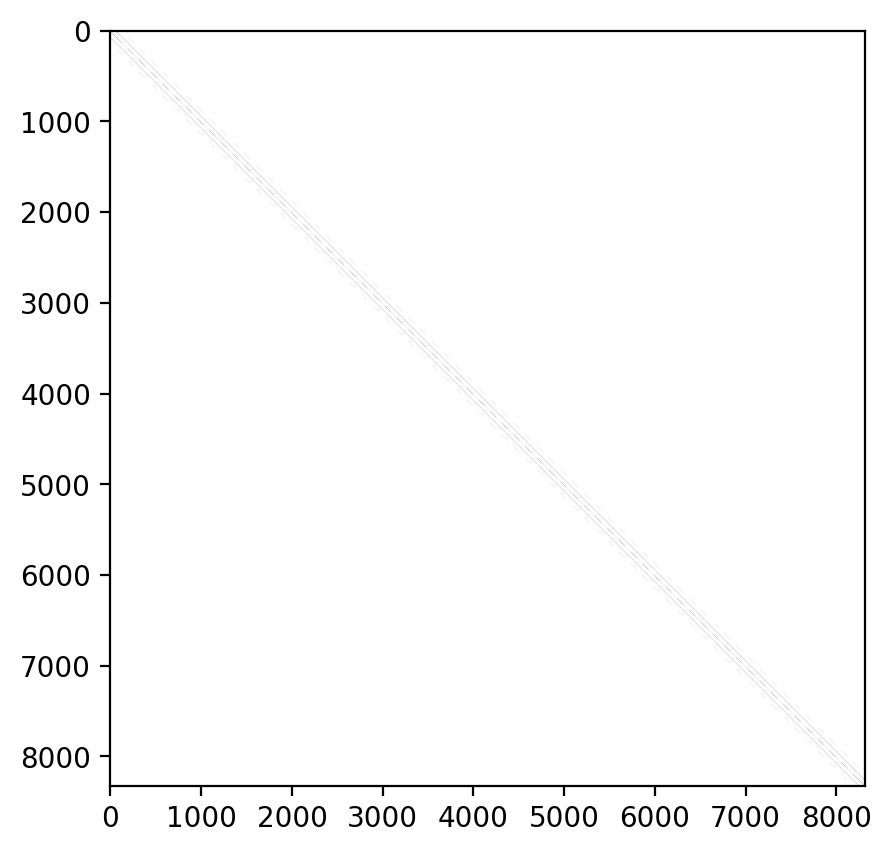

In [6]:
# Plot the matrix to solve
fig = plt.figure(figsize=(5,5),dpi=200)
plt.imshow(A!=0,cmap=cm.binary)

A = csc_matrix(A,dtype=float)

In [7]:
# Finally use a sparse solving algorithm
U_next = spsolve(A,B)
U_next

array([ 1.07033183e-11,  1.34272247e-11,  2.55913903e-12, ...,
        2.96758047e-72, -2.10958397e-73,  3.97790222e-73])